### Spectral Analysis of Graphs

In this notebook, we perform **spectral analysis** on a graph to extract  features that capture the global structure of the network. 

---

#### **Graph Laplacian**

The **graph Laplacian** is a matrix representation of a graph that encodes its structure. For a graph $G = (V, E)$ with $n$ nodes, the Laplacian matrix $L$ is defined as:
$$
L = D - A
$$
where:
- $A$ is the adjacency matrix of the graph, where $A_{ij} = 1$ if there is an edge between nodes $i$ and $j$, and $0$ otherwise.
- $D$ is the degree matrix, a diagonal matrix where $D_{ii}$ is the degree of node $i$ (i.e., the number of edges connected to node $i$).

For the **normalized Laplacian**, which is often used in spectral analysis, the formula is:
$$
L_{\text{norm}} = I - D^{-1/2} A D^{-1/2}
$$
where $I$ is the identity matrix.

---

#### **Spectral Decomposition**

The Laplacian matrix $L$ is symmetric and positive semi-definite, meaning it can be decomposed into eigenvalues and eigenvectors:
$$
L = Q \Lambda Q^\top
$$
where:
- $Q$ is an orthogonal matrix whose columns are the eigenvectors of $L$.
- $\Lambda$ is a diagonal matrix containing the eigenvalues $\lambda_1, \lambda_2, \dots, \lambda_n$ of $L$.

The eigenvalues and eigenvectors of the Laplacian provide important insights into the graph:
- The **smallest eigenvalue** of $L$ is always $0$, and its corresponding eigenvector is constant.
- The **second smallest eigenvalue** (called the **algebraic connectivity** or **Fiedler value**) indicates how well-connected the graph is.
- The eigenvectors corresponding to the smallest eigenvalues encode the **global structure** of the graph and can be used for tasks like clustering and dimensionality reduction.

---


In [56]:
import os
import sys
import os.path
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import scipy.sparse as sp
import scipy.stats as st
import math
import gzip
import colorsys
import pickle as pk
import pandas as pd
from collections import defaultdict, Counter, ChainMap
import umap
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster

import matplotlib.pyplot as plt
# %matplotlib inline

### Gene ID Mapping Preprocessing

This code downloads and parses the NCBI gene info file for Homo sapiens to precompute mappings between gene symbols, Entrez IDs, and Ensembl IDs. It creates dictionaries for quick lookups (e.g., `symbol_to_entrez`, `symbol_to_ensembl`) and provides functions to convert gene symbols to Entrez or Ensembl IDs. These mappings are essential for consistent identifier conversion in downstream analyses.

In [26]:


def download_mapping_file(url, filename):
    urllib.request.urlretrieve(url, filename)

def parse_mapping_file(filename):
    mapping = {}
    with gzip.open(filename, 'rt') as file:
        for line in file:
            if line.startswith('#'):  # Skip header and comments
                continue
            fields = line.strip().split('\t')
            if fields[0] == '9606':
                gene_symbol = fields[2]
                entrez_id = fields[1]
                ensembl_id = fields[5]
                # Additional mapping field
                gene_name = fields[11]
                if gene_symbol not in mapping:
                    mapping[gene_symbol] = {
                        'entrez_id': entrez_id,
                        'ensembl_id': ensembl_id,
                        'gene_name': gene_name
                    }
    return mapping


def convert_symbols_to_entrez(gene_symbols, mapping):
    entrez_ids = []
    for symbol in gene_symbols:
        if symbol in mapping:
            entrez_ids.append(mapping[symbol]['entrez_id'])
    return entrez_ids

def convert_symbols_to_ensembl(gene_symbols, mapping):
    ensembl_ids = []
    for symbol in gene_symbols:
        if symbol in mapping:
            ensembl_ids.append(mapping[symbol]['ensembl_id'])
    return ensembl_ids

# # Download Gene Info file (example using Homo sapiens)
url = 'ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz'
filename = 'Homo_sapiens.gene_info.gz'
download_mapping_file(url, filename)

# Parse mapping file
mapping = parse_mapping_file(filename)

# Generate a dictionary of all existing gene symbols and their corresponding Entrez IDs and Ensemble IDs
all_gene_symbols = list(mapping.keys())
all_entrez_ids = [mapping[symbol]['entrez_id'] for symbol in all_gene_symbols]
all_ensembl_ids = [mapping[symbol]['ensembl_id'] for symbol in all_gene_symbols]
symbol_to_entrez = dict(zip(all_gene_symbols, all_entrez_ids))
symbol_to_ensembl = dict(zip(all_gene_symbols, all_ensembl_ids))
entrez_to_symbols = {v: k for k, v in symbol_to_entrez.items()}
ensembl_to_symbols = {v: k for k, v in symbol_to_ensembl.items()}


### load PPI network

Choose your PPI network from this list


| Graph Name          | # Nodes | # Edges | # Components | Density   | Avg Degree |
|---------------------|---------|---------|--------------|-----------|------------|
| PPI_direct_elist    | 15,935  | 170,562 | 10           | 0.134 %   | 21.41      |
| PPI_physical_elist  | 18,068  | 306,914 | 2            | 0.188 %   | 33.97      |
| PPI_full_elist      | 19,970  | 772,282 | 1            | 0.387 %   | 77.34      |

In [27]:
def Ginfo(G):
    info = []
    info.append(f"Graph Name: {G.name}")
    info.append(f"Graph Type: {type(G).__name__}")
    info.append(f"Number of Nodes: {G.number_of_nodes()}")
    info.append(f"Number of Edges: {G.number_of_edges()}")
    info.append(f"Density: {round(100.*nx.density(G),3)} %")
    info.append(f"Average Degree: {round(sum(dict(G.degree()).values()) / G.number_of_nodes(),2)}")
    info.append(f"Connected: {'Yes' if nx.is_connected(G) else 'No'}")
    num_components = nx.number_connected_components(G)
    info.append(f"Number of Connected Components: {num_components}")
   
    info.append(f"Directed: {'Yes' if G.is_directed() else 'No'}")
    return "\n".join(info)
    return info

In [58]:

# PPI direct
path = 'data/'
G_ppi = nx.read_edgelist(path + 'PPI_direct_elist.csv',data=False, delimiter=',')
print(Ginfo(G_ppi))
print('\n')

lcc = max(nx.connected_components(G_ppi), key=len)
G = nx.subgraph(G_ppi,lcc)

print(Ginfo(G))

Graph Name: 
Graph Type: Graph
Number of Nodes: 15935
Number of Edges: 170562
Density: 0.134 %
Average Degree: 21.41
Connected: No
Number of Connected Components: 10
Directed: No


Graph Name: 
Graph Type: Graph
Number of Nodes: 15915
Number of Edges: 170551
Density: 0.135 %
Average Degree: 21.43
Connected: Yes
Number of Connected Components: 1
Directed: No


### spectral decomposition

of the symmetric Laplacian 
(takes 0.5-1 hrs)

you can make a test run with a smaller sample (see optional next cell)


In [ ]:

n = 5000  # Number of nodes to sample

# Randomly sample n nodes from the graph
sampled_nodes = rd.sample(list(G.nodes()), n)

# Create a subgraph with the sampled nodes
sampled_subgraph = G.subgraph(sampled_nodes)

# Extract the largest connected component (LCC)
lcc = max(nx.connected_components(sampled_subgraph), key=len)
G_lcc_sample = G.subgraph(lcc)

print(Ginfo(G_lcc_sample))

Graph Name: 
Graph Type: Graph
Number of Nodes: 4246
Number of Edges: 17236
Density: 0.191 %
Average Degree: 8.12
Connected: Yes
Number of Connected Components: 1
Directed: No


In [30]:

# Compute the normalized Laplacian matrix
M_laplace = nx.normalized_laplacian_matrix(G_lcc_sample, sorted(G_lcc_sample.nodes()))

n_nodes = G_lcc_sample.number_of_nodes()

# Compute the n_lam largest eigenvalues and eigenvectors of M_Laplace
Lam, M_V = sp.linalg.eigsh(M_laplace, k=n_nodes-1, which='LM')

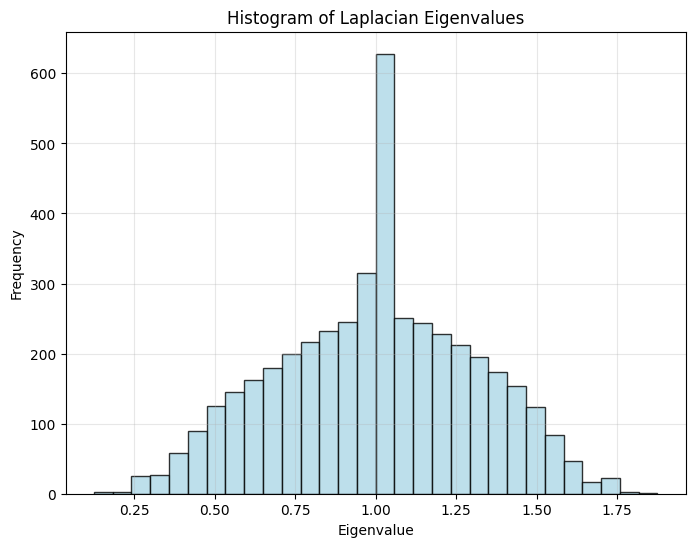

In [31]:

# Plot the eigenvalues as a histogram
plt.figure(figsize=(8, 6))
plt.hist(Lam, bins=30, color='lightblue', edgecolor='black', alpha=0.8)
plt.title("Histogram of Laplacian Eigenvalues")
plt.xlabel("Eigenvalue")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()